In [1]:
%autosave 60
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sof1 = pd.read_csv("D:/OneDrive/jwd/Research_Data/FJJD_Sex_Offender_Prediction/JSO_Recidivism_Sample_File.csv")
sof2 = pd.read_csv("D:/OneDrive/jwd/Research_Data/FJJD_Sex_Offender_Prediction/JSO_Recidivism_Sample_File_2nd.csv")
sof = sof1.append(sof2,ignore_index=True)


sof.drop('sexrediccharge', axis=1, inplace=True)
sof.drop('d91q7a6', axis=1, inplace=True)

sof.djjid = sof.djjid.astype(str)

sof.dob=pd.to_datetime(sof.dob) # converts datetime format
from datetime import date
sof.today=pd.to_datetime(date.today())

age_in_years= (sof.today - sof.dob)
age_in_years [2]

counties=pd.get_dummies(sof.homecnty, prefix='county')
counties.shape

days=[int(i.days) for i in (sof.today - sof.dob)]
df = pd.DataFrame([pd.Series(days)]).T

sof['age_in_days'] = df[0]

sof['age_in_years']= np.round(sof.age_in_days.astype(float)/365, 2)
#sof.age_in_years

sof = sof.join(counties)
sof.shape

judcir = pd.get_dummies(sof.jcircuit, prefix='judicial_circuit')
sof = sof.join(judcir)
offen46 = pd.get_dummies(sof.offen46, prefix='offen46')

sof = sof.join(offen46)
sof['initial_sexcat'] =sof.category.map({1:1, 2:0})
sof['initial_sexcat'].value_counts(dropna=False)

degree = pd.get_dummies(sof.degree, prefix='degree')
degree.shape

sof = sof.join(degree)

Autosaving every 60 seconds


In [2]:
sof.shape

(2000, 663)

In [3]:
# LASSO RESULTS *** I run all variables and they seem to be most important ones.

X=[ 
 'd62q5a2',  
'd11q5a5',  
'd10q2a4', 

              'd12q8a3',
              'd32q6a3', 
       
              'd10q8a3', 
              'd91q8a1', 
              'd1q6a1',   
              'd12q5a2', 
              'd32q8a1', 
              'ageat1stsexoff',   
              'd12q2a2', 
              'judicial_circuit_1',
              'judicial_circuit_10',
              'd91q10a1',  
              'd11q3a3', 
              'd31q1a2', 
              'judicial_circuit_4',
              'd10q11a3',
              'd12q10a3', 
             'daystorecid',  
            
            'd32q10a3', 
              'd32q10a5',
              'd10q1a3', 
              'd32q5a2', 
              'd32q8a4', 
 
              'd11q5a6',
              'd72q4a2',
              'youthgender', 
              'd10q2a3',
      
              'd32q4a1',
              'd32q9a3', 
              'd81q2a2', 
              'd11q6a7',
              'judicial_circuit_7', 
              'd1q8a3',
            
            'd1q10a2', 
              'd52q1a3', 

              'd62q3a1', 
              'd92q2a1', 



              'd72q1a4', 

              'd92q2a3', 


              'd1q4a1',


              'd92q2a2', 


              'd62q3a3', 
              'd11q6a4',
             'd42q1a4', 


              'd91q1a6',
              'd72q1a5',
              'd92q1a1', 
              'd91q11a2', 
              'd42q2a3',
              'd72q1a12',
'd52q2a5',
'd91q5a1', 
'd72q1a15',            
'offen46_5',
'county_12', 
'county_5', 
'county_25' ]
X = pd.DataFrame(sof, columns=[X])
y = sof.ix[:,1]

In [4]:
print X.shape
print y.value_counts()

(2000, 60)
0    1830
1     170
Name: sexrecidivism, dtype: int64


# Normal Sampling

In [5]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=3)
print(X_train.shape)
print (X_test.shape)

(1400, 60)
(600, 60)


C:\Anaconda3\envs\py27\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
print y_test.value_counts()

0    549
1     51
Name: sexrecidivism, dtype: int64


# GRADIENT BOOSTING--Normal Sample

Running the Suggested Model

In [147]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
GB = GradientBoostingClassifier(n_estimators=70, max_depth=10, min_samples_split=8, random_state=3)
GB.fit(X_train, y_train)
y_train_hat_GB = GB.predict(X_train)
print(metrics.accuracy_score(y_train, y_train_hat_GB))
y_test_hat_GB = GB.predict(X_test)
print  "Test_Score:", (metrics.accuracy_score(y_test, y_test_hat_GB))
# predict probability of rearrest
y_pred_prob_gb = GB.predict_proba(X_test)[:,1] 
# calculate AUC
print metrics.roc_auc_score(y_test, y_pred_prob_gb)

1.0
Test_Score: 0.93
0.865352334012


In [148]:
gb=pd.crosstab(y_test, y_test_hat_GB, rownames=['True'], colnames=['Predicted'], margins=True)
gb

Predicted,0,1,All
True,,,
0,535,14,549
1,28,23,51
All,563,37,600


In [9]:
TN = gb[0][0]
FN = gb[0][1]
FP = gb[1][0]
TP = gb[1][1]
print "True Negative: (TN)", TN 
print "True Positive (TP):", TP 
print "False Negative (FN):", FN 
print "False Positive (FP):", FP 
from __future__ import division
print( "Sensitivity-True positive rate (TPR) (Hit Rate or Recall)", round(TP/(TP+FN),3) )
print "Precision or positive predictive value (PPV)", round(TP/(TP+FP),3)
print "Specificity-True Negative Rate (TNR)", round(TN/(TN+FP),3) 
print "False Negative Rate (FNR) (Miss Rate)", round(FN/(FN+TP),3) 
print "False Positive Rate (FPR) (Fall-out Rate)", round(FP/(FP+TN),3) 
FPR=round(FP/(FP+TN),3) 

True Negative: (TN) 535
True Positive (TP): 23
False Negative (FN): 28
False Positive (FP): 14
('Sensitivity-True positive rate (TPR) (Hit Rate or Recall)', 0.451)
Precision or positive predictive value (PPV) 0.622
Specificity-True Negative Rate (TNR) 0.974
False Negative Rate (FNR) (Miss Rate) 0.549
False Positive Rate (FPR) (Fall-out Rate) 0.026


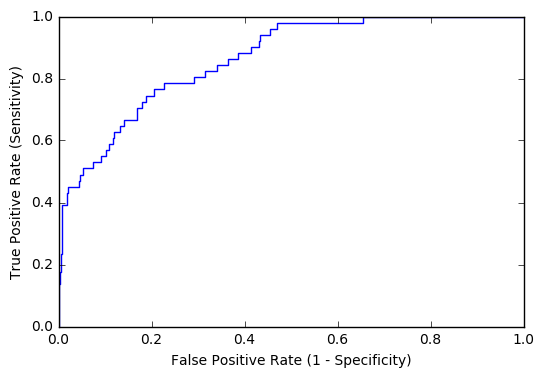

In [10]:
# plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob_gb)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

# Logistic Regression--Normal Sample

# Logisic Regression GridSearch

In [12]:
# Logistic regression does not have as many parameters as other algorithms as to fine-tune. Still, I fine-tune L1 and L2.
penalty='l2'
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
lg = LogisticRegression(random_state=3 ) 
param_grid = { "penalty" : ['l1', 'l2'] } 
grid_search = GridSearchCV(estimator=lg, param_grid=param_grid, cv=10, scoring = 'recall') 
grid_search.fit(X, y)
#summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_)) 
for params, mean_score, scores in grid_search.grid_scores_: 
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

Best: 0.211765 using {'penalty': 'l1'}
0.211765 (0.079792) with: {'penalty': 'l1'}
0.194118 (0.083397) with: {'penalty': 'l2'}


Running the suggested model on normal sample (no probability-adjusted)

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression(penalty= 'l1', random_state=3 )
logreg.fit(X_train, y_train)
y_hat_train_log = logreg.predict(X_train)
print "Train_Accuracy", metrics.accuracy_score(y_train, y_hat_train_log)
y_test_hat_log = logreg.predict(X_test )
print "Test_Accuracy:", metrics.accuracy_score(y_test, y_test_hat_log)  

# predict probability of rearrest
y_test_prob_log = logreg.predict_proba(X_test )[:, 1]

# calculate AUC
print "CORRECT_AUC_USING_PROB", metrics.roc_auc_score(y_test, y_test_prob_log)

Train_Accuracy 0.939285714286
Test_Accuracy: 0.916666666667
CORRECT_AUC_USING_PROB 0.796992749741


In [16]:
log=pd.crosstab(y_test, y_test_hat_log, rownames=['True'], colnames=['Predicted'], margins=True)
log

Predicted,0,1,All
True,,,
0,542,7,549
1,43,8,51
All,585,15,600


In [17]:
TN = log[0][0]
FN = log[0][1]
FP = log[1][0]
TP = log[1][1]
print "True Negative: (TN)", TN 
print "True Positive (TP):", TP 
print "False Negative (FN):", FN 
print "False Positive (FP):", FP 
from __future__ import division
print "Sensitivity-True positive rate (TPR) (Hit Rate or Recall", round(TP/(TP+FN),3) 
print "Precision or positive predictive value (PPV)", round(TP/(TP+FP),3)
print "Specificity-True Negative Rate (TNR)", round(TN/(TN+FP),3) 
print "False Negative Rate (FNR) (Miss Rate)", round(FN/(FN+TP),3) 
print "False Positive Rate (FPR) (Fall-out Rate)", round(FP/(FP+TN),3) 
FPR=round(FP/(FP+TN),3) 

True Negative: (TN) 542
True Positive (TP): 8
False Negative (FN): 43
False Positive (FP): 7
Sensitivity-True positive rate (TPR) (Hit Rate or Recall 0.157
Precision or positive predictive value (PPV) 0.533
Specificity-True Negative Rate (TNR) 0.987
False Negative Rate (FNR) (Miss Rate) 0.843
False Positive Rate (FPR) (Fall-out Rate) 0.013


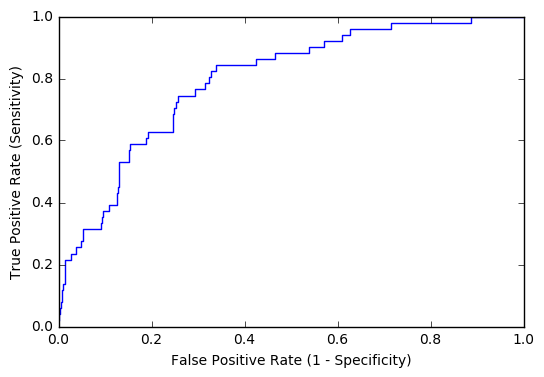

In [18]:
# plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_prob_log)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

# Random Forests-Normal Sample 

# Random Forest Grid Search

In [22]:
from sklearn import metrics 
from sklearn.grid_search import GridSearchCV 
from sklearn.ensemble import RandomForestClassifier 
forest = RandomForestClassifier(n_estimators =100 , max_depth=10, random_state=3) # n_estimators are the number of trees 
param_grid = { 'n_estimators': [50, 60, 70, 100], 
              'max_features': ['auto', 'sqrt', 'log2'], 
              'max_depth' : [10] }
grid = GridSearchCV(estimator=forest, param_grid=param_grid, cv= 10) 
grid_result=grid.fit(X, y)
#summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) 
for params, mean_score, scores in grid_result.grid_scores_: 
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

Best: 0.928500 using {'max_features': 'auto', 'n_estimators': 50, 'max_depth': 10}
0.928500 (0.007762) with: {'max_features': 'auto', 'n_estimators': 50, 'max_depth': 10}
0.928000 (0.007483) with: {'max_features': 'auto', 'n_estimators': 60, 'max_depth': 10}
0.927500 (0.005590) with: {'max_features': 'auto', 'n_estimators': 70, 'max_depth': 10}
0.927000 (0.005568) with: {'max_features': 'auto', 'n_estimators': 100, 'max_depth': 10}
0.928500 (0.007762) with: {'max_features': 'sqrt', 'n_estimators': 50, 'max_depth': 10}
0.928000 (0.007483) with: {'max_features': 'sqrt', 'n_estimators': 60, 'max_depth': 10}
0.927500 (0.005590) with: {'max_features': 'sqrt', 'n_estimators': 70, 'max_depth': 10}
0.927000 (0.005568) with: {'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 10}
0.921500 (0.003905) with: {'max_features': 'log2', 'n_estimators': 50, 'max_depth': 10}
0.922000 (0.004000) with: {'max_features': 'log2', 'n_estimators': 60, 'max_depth': 10}
0.922000 (0.004000) with: {'max_fea

Running Suggested Models

In [23]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators =50 ,max_depth=10, random_state=3)   # n_estimators are the number of trees
forestfit_train = forest.fit(X_train,y_train)
y_train_hat_RF = forest.predict(X_train)
print "Train", (metrics.accuracy_score(y_train, y_train_hat_RF))
y_test_hat_RF = forest.predict(X_test)
print "Test",(metrics.accuracy_score(y_test, y_test_hat_RF))
y_pred_prob_rf=forest.predict_proba(X_test)[:,1]

# calculate AUC
print "CORRECT_AUC_USING_PROB", metrics.roc_auc_score(y_test, y_pred_prob_rf)

Train 0.957142857143
Test 0.926666666667
CORRECT_AUC_USING_PROB 0.859244973035


In [24]:
rf=pd.crosstab(y_test, y_test_hat_RF, rownames=['True'], colnames=['Predicted'], margins=True)
rf

Predicted,0,1,All
True,,,
0,549,0,549
1,44,7,51
All,593,7,600


In [25]:
TN = rf[0][0]
FN = rf[0][1]
FP = rf[1][0]
TP = rf[1][1]
print "True Negative: (TN)", TN 
print "True Positive (TP):", TP 
print "False Negative (FN):", FN 
print "False Positive (FP):", FP 
from __future__ import division
print( "Sensitivity-True positive rate (TPR) (Hit Rate or Recall)", round(TP/(TP+FN),3) )
print "Precision or positive predictive value (PPV)", round(TP/(TP+FP),3)
print "Specificity-True Negative Rate (TNR)", round(TN/(TN+FP),3) 
print "False Negative Rate (FNR) (Miss Rate)", round(FN/(FN+TP),3) 
print "False Positive Rate (FPR) (Fall-out Rate)", round(FP/(FP+TN),3) 
FPR=round(FP/(FP+TN),3)

True Negative: (TN) 549
True Positive (TP): 7
False Negative (FN): 44
False Positive (FP): 0
('Sensitivity-True positive rate (TPR) (Hit Rate or Recall)', 0.137)
Precision or positive predictive value (PPV) 1.0
Specificity-True Negative Rate (TNR) 1.0
False Negative Rate (FNR) (Miss Rate) 0.863
False Positive Rate (FPR) (Fall-out Rate) 0.0


# If we set the probability > ??

In [116]:
import numpy as np
from sklearn.metrics import precision_recall_curve
y_true = np.array([0, 0, 1, 1, 0,0])
y_scores = np.array([0.1, 0.4, 0.35, 0.8,2,8])
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_gb)

In [ ]:
# plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob_gb)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

# Gradient Boosting -Normal Sample - P> 0.15

In [ ]:
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
GB = GradientBoostingClassifier(random_state=3) 
param_grid = { "n_estimators" : [50, 70, 100, 125], 
              "learning_rate" : [0.01, 0.05, 0.1, 0.15], 
              "max_depth" : [10, 15, 20], 
              "min_samples_split" : [8, 9, 10] } 
grid_search = GridSearchCV(estimator=GB, param_grid=param_grid, cv=10, scoring = 'recall') 
grid_search.fit(X, y)
# predict probability of rearrest
y_pred_prob_gb = grid_search.predict_proba(X)[:,1]
#summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_)) 
for params, mean_score, scores in grid_search.grid_scores_: 
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))
#Result Best: 0.441176 using {'min_samples_split': 10, 'n_estimators': 70, 'learning_rate': 0.1, 'max_depth': 10}

In [173]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
GB = GradientBoostingClassifier(n_estimators=70, max_depth=15, min_samples_split=8, random_state=3, learning_rate= 0.1)
GB.fit(X_train, y_train)
y_train_hat_GB = GB.predict(X_train)
print(metrics.accuracy_score(y_train, y_train_hat_GB))
risk = [0.05, 0.08, 0.10, 0.15, 0.20, 0.25, 0.30, 0.40, 0.5,0.6, 0.60, 0.70, 0.90]
precision_gb = []
recall_gb = []
for i in risk:
    y_test_hat_gb = (GB.predict_proba(X_test)[:,1] > i).astype(int)
    precision_gb.append(metrics.precision_score(y_test, y_test_hat_gb))
    recall_gb.append(metrics.recall_score(y_test, y_test_hat_gb))
# predict probability of rearrest
y_pred_prob_gb = GB.predict_proba(X_test )[:,1] 
# calculate AUC
print "AUC:",metrics.roc_auc_score(y_test, y_pred_prob_gb)

1.0
AUC: 0.871513268331


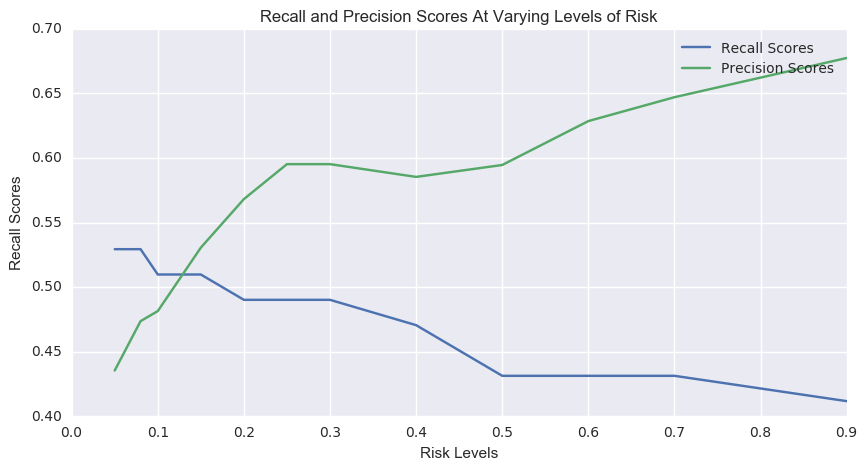

In [174]:
from matplotlib import pyplot as plt
import seaborn as sns 
plt.figure(figsize=(10,5)) 
plt.plot(risk, recall_gb, label="Recall Scores")
plt.plot(risk, precision_gb, label="Precision Scores")
plt.legend()
plt.xlabel('Risk Levels') 
plt.ylabel('Recall Scores') 
plt.title('Recall and Precision Scores At Varying Levels of Risk') 
plt.show()

In [175]:
y_test_hat_gb = (GB.predict_proba(X_test)[:,1] > 0.07).astype(int)
precision_gb.append(metrics.precision_score(y_test, y_test_hat_gb))
recall_gb.append(metrics.recall_score(y_test, y_test_hat_gb))

In [176]:
gb=pd.crosstab(y_test, y_test_hat_gb, rownames=['True'], colnames=['Predicted'], margins=True)
gb

Predicted,0,1,All
True,,,
0,518,31,549
1,24,27,51
All,542,58,600


In [113]:
TN = gb[0][0]
FN = gb[0][1]
FP = gb[1][0]
TP = gb[1][1]
print "True Negative: (TN)", TN 
print "True Positive (TP):", TP 
print "False Negative (FN):", FN 
print "False Positive (FP):", FP 
from __future__ import division
print "Sensitivity-True positive rate (TPR) (Hit Rate or Recall", round(TP/(TP+FN),3)
print "Precision or positive predictive value (PPV)", round(TP/(TP+FP),3)
print "Specificity-True Negative Rate (TNR)", round(TN/(TN+FP),3) 
print "False Negative Rate (FNR) (Miss Rate)", round(FN/(FN+TP),3) 
print "False Positive Rate (FPR) (Fall-out Rate)", round(FP/(FP+TN),3) 
FPR=round(FP/(FP+TN),3) 

True Negative: (TN) 526
True Positive (TP): 26
False Negative (FN): 25
False Positive (FP): 23
Sensitivity-True positive rate (TPR) (Hit Rate or Recall 0.51
Precision or positive predictive value (PPV) 0.531
Specificity-True Negative Rate (TNR) 0.958
False Negative Rate (FNR) (Miss Rate) 0.49
False Positive Rate (FPR) (Fall-out Rate) 0.042


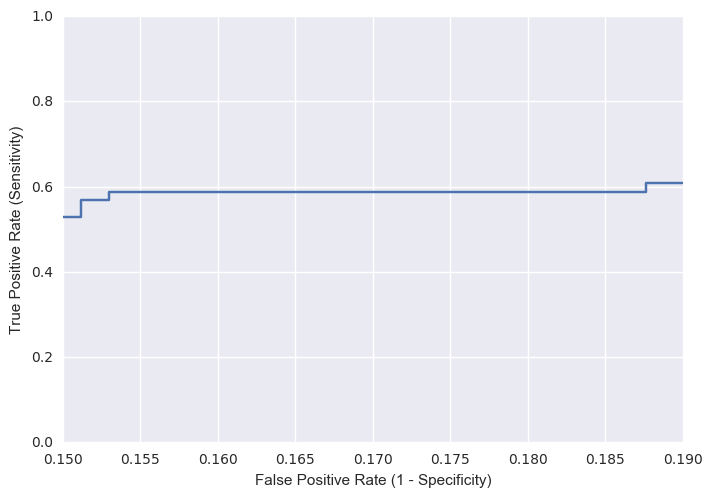

In [116]:
# plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob_gb)
plt.plot(fpr, tpr)
plt.xlim([0.15, 0.19])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

# Logistic Regression--Normal Sample--P>0.125

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression(random_state=3 )
logreg.fit(X_train, y_train)
y_hat_train_log = logreg.predict(X_train)
print "Train_Accuracy", metrics.accuracy_score(y_train, y_hat_train_log)

risk = [0.05, 0.08, 0.10, 0.15, 0.20, 0.25, 0.30, 0.40, 0.5,0.6, 0.60, 0.70, 0.90]
precision_log = []
recall_log = []

for i in risk:
    y_test_hat_log = (logreg.predict_proba(X_test)[:,1] > i).astype(int)
    precision_log.append(metrics.precision_score(y_test, y_test_hat_log))
    recall_log.append(metrics.recall_score(y_test, y_test_hat_log))
# predict probability of rearrest
y_pred_prob_log = logreg.predict_proba(X_test )[:,1] 
# calculate AUC
print "AUC:",metrics.roc_auc_score(y_test, y_pred_prob_log)

Train_Accuracy 0.940714285714
AUC: 0.812886174506


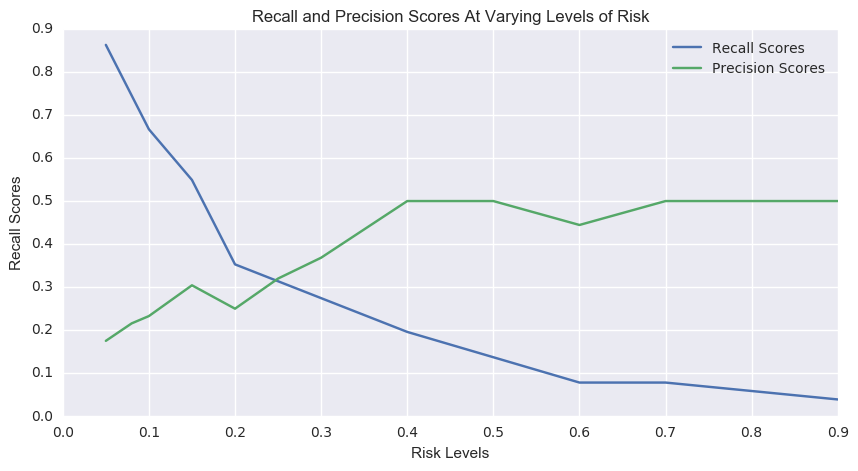

In [83]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,5)) 
plt.plot(risk, recall_log, label="Recall Scores")
plt.plot(risk, precision_log, label="Precision Scores")
plt.legend()
plt.xlabel('Risk Levels') 
plt.ylabel('Recall Scores') 
plt.title('Recall and Precision Scores At Varying Levels of Risk') 
plt.show()

In [107]:
y_test_hat_log = (logreg.predict_proba(X_test)[:,1] > 0.13).astype(int)
precision_log.append(metrics.precision_score(y_test, y_test_hat_log))
recall_log.append(metrics.recall_score(y_test, y_test_hat_log))

In [108]:
log=pd.crosstab(y_test, y_test_hat_log, rownames=['True'], colnames=['Predicted'], margins=True)
log

Predicted,0,1,All
True,,,
0,470,79,549
1,21,30,51
All,491,109,600


In [100]:
TN = log[0][0]
FN = log[0][1]
FP = log[1][0]
TP = log[1][1]
print "True Negative: (TN)", TN 
print "True Positive (TP):", TP 
print "False Negative (FN):", FN 
print "False Positive (FP):", FP 
from __future__ import division
print "Sensitivity-True positive rate (TPR) (Hit Rate or Recall", round(TP/(TP+FN),3) 
print "Precision or positive predictive value (PPV)", round(TP/(TP+FP),3)
print "Specificity-True Negative Rate (TNR)", round(TN/(TN+FP),3) 
print "False Negative Rate (FNR) (Miss Rate)", round(FN/(FN+TP),3) 
print "False Positive Rate (FPR) (Fall-out Rate)", round(FP/(FP+TN),3) 
FPR=round(FP/(FP+TN),3) 

True Negative: (TN) 485
True Positive (TP): 28
False Negative (FN): 23
False Positive (FP): 64
Sensitivity-True positive rate (TPR) (Hit Rate or Recall 0.549
Precision or positive predictive value (PPV) 0.304
Specificity-True Negative Rate (TNR) 0.883
False Negative Rate (FNR) (Miss Rate) 0.451
False Positive Rate (FPR) (Fall-out Rate) 0.117


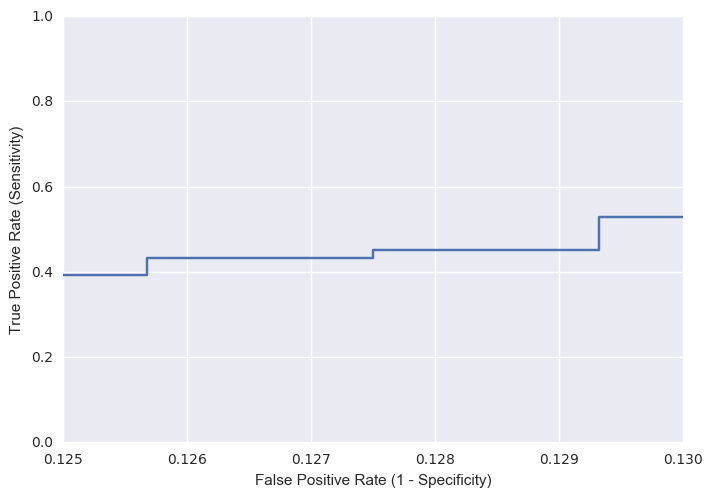

In [104]:
# plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_prob_log)
plt.plot(fpr, tpr)
plt.xlim([0.125, 0.13])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

# Random Forest--Normal Sample-- p>0.128

In [123]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators =50 ,max_depth=10, random_state=3)   # n_estimators are the number of trees
forestfit_train = forest.fit(X_train,y_train)
y_train_hat_RF = forest.predict(X_train)
print "Train", (metrics.accuracy_score(y_train, y_train_hat_RF))
y_test_hat_RF = (forest.predict_proba(X_test )[:,1] > 0.08).astype(int)
print "Test",(metrics.accuracy_score(y_test, y_test_hat_RF))
y_pred_prob_rf=forest.predict_proba(X_test)[:,1]

risk = [0.05, 0.08, 0.10, 0.15, 0.20, 0.25, 0.30, 0.40, 0.5,0.6, 0.60, 0.70, 0.90]
precision_rf = []
recall_rf = []

for i in risk:
    y_test_hat_rf = (forest.predict_proba(X_test)[:,1] > i).astype(int)
    precision_rf.append(metrics.precision_score(y_test, y_test_hat_rf))
    recall_rf.append(metrics.recall_score(y_test, y_test_hat_rf))
# predict probability of rearrest
y_pred_prob_rf = forest.predict_proba(X_test )[:,1] 
# calculate AUC
print "AUC:",metrics.roc_auc_score(y_test, y_pred_prob_rf)

Train 0.957142857143
Test 0.675
AUC: 0.859244973035


C:\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


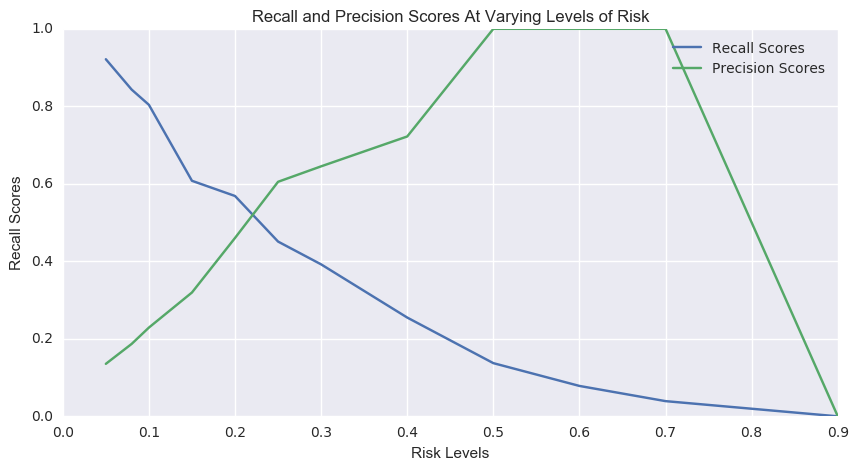

In [124]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,5)) 
plt.plot(risk, recall_rf, label="Recall Scores")
plt.plot(risk, precision_rf, label="Precision Scores")
plt.legend()
plt.xlabel('Risk Levels') 
plt.ylabel('Recall Scores') 
plt.title('Recall and Precision Scores At Varying Levels of Risk') 
plt.show()

In [140]:
y_test_hat_rf = (forest.predict_proba(X_test)[:,1] > 0.16).astype(int)
precision_rf.append(metrics.precision_score(y_test, y_test_hat_rf))
recall_rf.append(metrics.recall_score(y_test, y_test_hat_rf))

In [141]:
rf=pd.crosstab(y_test, y_test_hat_rf, rownames=['True'], colnames=['Predicted'], margins=True)
rf

Predicted,0,1,All
True,,,
0,489,60,549
1,21,30,51
All,510,90,600


In [142]:
TN = rf[0][0]
FN = rf[0][1]
FP = rf[1][0]
TP = rf[1][1]
print "True Negative: (TN)", TN 
print "True Positive (TP):", TP 
print "False Negative (FN):", FN 
print "False Positive (FP):", FP 
from __future__ import division
print( "Sensitivity-True positive rate (TPR) (Hit Rate or Recall)", round(TP/(TP+FN),3) )
print "Precision or positive predictive value (PPV)", round(TP/(TP+FP),3)
print "Specificity-True Negative Rate (TNR)", round(TN/(TN+FP),3) 
print "False Negative Rate (FNR) (Miss Rate)", round(FN/(FN+TP),3) 
print "False Positive Rate (FPR) (Fall-out Rate)", round(FP/(FP+TN),3) 
FPR=round(FP/(FP+TN),3) 

True Negative: (TN) 489
True Positive (TP): 30
False Negative (FN): 21
False Positive (FP): 60
('Sensitivity-True positive rate (TPR) (Hit Rate or Recall)', 0.588)
Precision or positive predictive value (PPV) 0.333
Specificity-True Negative Rate (TNR) 0.891
False Negative Rate (FNR) (Miss Rate) 0.412
False Positive Rate (FPR) (Fall-out Rate) 0.109


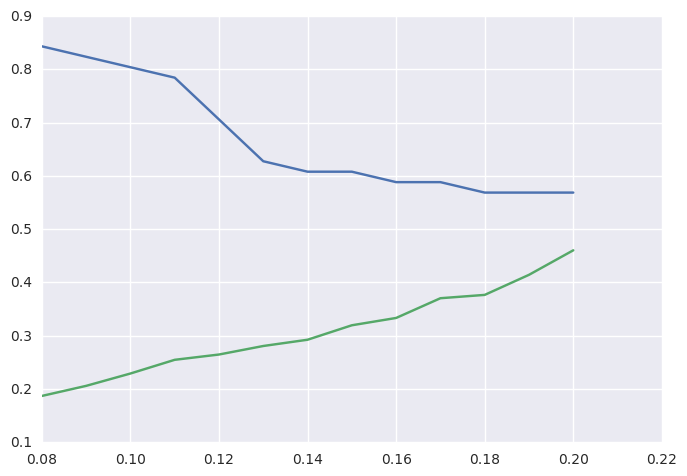

In [143]:
# Plot hits on a probability window
window=[0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15,0.16,0.17,0.18,0.19,0.2]
precision_rf2 = []
recall_rf2 = []

for i in window:
    y_test_hat_rf2 = (forest.predict_proba(X_test)[:,1] > i).astype(int)
    precision_rf2.append(metrics.precision_score(y_test, y_test_hat_rf2))
    recall_rf2.append(metrics.recall_score(y_test, y_test_hat_rf2))
plt.plot(window, recall_rf2)
plt.plot(window, precision_rf2)

In [46]:
'''We selected features that play major roles. Now we have to deal with the problem of imbalance. 
We will systematically overpopulate the minority class.'''

'We selected features that play major roles. Now we have to deal with the problem of imbalance. \nWe will systematically overpopulate the minority class.'

In [144]:
gb

Predicted,0,1,All
True,,,
0,526,23,549
1,25,26,51
All,551,49,600


In [145]:
log

Predicted,0,1,All
True,,,
0,470,79,549
1,21,30,51
All,491,109,600


In [146]:
rf

Predicted,0,1,All
True,,,
0,489,60,549
1,21,30,51
All,510,90,600


In [ ]:
************************************************** IGNORE BELOW  *******************************************

In [6]:
jupyter nbconvert Data_Preprocessing_1.ipynb --to pdf

SyntaxError: invalid syntax (<ipython-input-6-698084ea844a>, line 1)

# Over Sampling

In [25]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=3)
X_train=X_train.values
X_test=X_test.values
print(X_train.shape)
print (X_test.shape)

(700L, 60L)
(300L, 60L)


In [186]:
# standardize predictors to have mean=0 and sd=1
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test= sc.transform(X_test)

In [19]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

print X_train.shape, y_train.shape
print X_test.shape,  y_test.shape
print X_val.shape,   y_val.shape

(700, 60) (700L,)
(150, 60) (150L,)
(150, 60) (150L,)


### Using ADASYN

In [36]:
from imblearn.over_sampling import ADASYN
ada = ADASYN(ratio=1.0, random_state=3)
adax, aday = ada.fit_sample(X_train, y_train)
aday.mean()
print adax.shape
print aday.shape

(1295L, 60L)
(1295L,)


In [19]:
adax

array([[ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [-0.79411864,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.35054212,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

### Using Smote

In [37]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=3)
smotx, smoty = sm.fit_sample(X_train, y_train)
print smotx.shape
print smoty.shape

(1292L, 60L)
(1292L,)


In [21]:
smotx

array([[ 1.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 1.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       ..., 
       [ 0.5350097,  0.       ,  0.       , ...,  0.5350097,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ]])

### Using Over_Sampling

In [38]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=3)
rosx, rosy = ros.fit_sample(X_train, y_train)
print rosx.shape
print rosy.shape

(1292L, 60L)
(1292L,)


In [ ]:
rosx

In [37]:
adax[5:15,1:60]

IndexError: too many indices for array

In [ ]:
rosx[5:15,1:60]

# Training with Overpopulated Sample and Testing Pure Test and Pure Validation Samples---ADASYN

In [49]:
#using train-test in adax and aday
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators =100 ,max_depth=15, random_state=3)   # n_estimators are the number of trees
forestfit_train = forest.fit(adax, aday)
y_train_hat_RF = forest.predict(adax)
print("ADASYN Sampling Train Accuracy", metrics.accuracy_score(aday, y_train_hat_RF))

#Test
y_test_hat_RF = forest.predict(X_test)
print("ADASYN Sampling Test Accuracy", metrics.accuracy_score(y_test, y_test_hat_RF))
# calculate AUC
y_test_prob_RF = forest.predict_proba(X_test) [:,1]
print "ADASYN Sampling Test AUC", "       ", metrics.roc_auc_score(y_test, y_test_prob_RF)

('ADASYN Sampling Train Accuracy', 0.95865834633385338)
('ADASYN Sampling Test Accuracy', 0.91000000000000003)
ADASYN Sampling Test AUC         0.831230497897


In [51]:
rfo=pd.crosstab(y_test, y_test_hat_RF, rownames=['True'], colnames=['Predicted'], margins=True)
rfo

Predicted,0,All
True,,
0,273,273
1,27,27
All,300,300


# Training with Overpopulated Sample and Testing Pure Test and Pure Validation Samples---Random Oversampling

In [52]:
#using train-test in rosx and rosy
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators =50 ,max_depth=10, random_state=3)   # n_estimators are the number of trees
forestfit_train = forest.fit(rosx, rosy)
y_train_hat_RF = forest.predict(rosx)
print("RandomOverSampling Train Accuracy", metrics.accuracy_score(rosy, y_train_hat_RF))

#Test
y_test_hat_RF = (forest.predict_proba(X_test) [:,1] >0.28).astype(int)
print("RandomOverSampling Test Accuracy", metrics.accuracy_score(y_test, y_test_hat_RF))
# calculate AUC
y_test_prob_RF = forest.predict_proba(X_test) [:,1]
print "RandomOverSampling Test Test AUC", "        ", metrics.roc_auc_score(y_test, y_test_prob_RF)

('RandomOverSampling Train Accuracy', 0.99690402476780182)
('RandomOverSampling Test Accuracy', 0.72666666666666668)
RandomOverSampling Test Test AUC          0.751051417718


In [53]:
rfo1=pd.crosstab(y_test, y_test_hat_RF, rownames=['True'], colnames=['Predicted'], margins=True)
rfo1

Predicted,0,1,All
True,,,
0,200,73,273
1,9,18,27
All,209,91,300


In [62]:
#Using -SMOTE

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 50,max_depth=10, random_state=3)   # n_estimators are the number of trees
forestfit_train = forest.fit( smotx, smoty)
y_train_hat_RF = forest.predict(smotx)
print("SMOTE Sampling Train Accuracy", metrics.accuracy_score(smoty, y_train_hat_RF))
print 

#Test
y_test_hat_RF =  (forest.predict_proba(X_test) [:,1] >0.5).astype(int)
print("SMOTE Sampling Test Accuracy", metrics.accuracy_score(y_test, y_test_hat_RF))
# calculate AUC
y_test_prob_RF = forest.predict_proba(X_test) [:,1]
print "SMOTE Sampling Test AUC", "        ", metrics.roc_auc_score(y_test, y_test_prob_RF)


('SMOTE Sampling Train Accuracy', 0.99767801857585137)

('SMOTE Sampling Test Accuracy', 0.92000000000000004)
SMOTE Sampling Test AUC          0.736535069868


In [63]:
rfo2=pd.crosstab(y_test, y_test_hat_RF, rownames=['True'], colnames=['Predicted'], margins=True)
rfo2

Predicted,0,1,All
True,,,
0,273,0,273
1,24,3,27
All,297,3,300


## Continuing with RANDOM OVERSAMPLING

In [14]:
# Let's create the samples from scratch.
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=3)
X_train=X_train.values
X_test=X_test.values
print(X_train.shape)
print (X_test.shape)

(700L, 60L)
(300L, 60L)


In [15]:
# standardize predictors to have mean=0 and sd=1
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test= sc.transform(X_test)

In [16]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=3, ratio = .60)
rosx, rosy = ros.fit_sample(X_train, y_train)
print rosx.shape
print rosy.shape

(1033L, 60L)
(1033L,)


In [17]:
rosy.mean()

0.37463697967086157

In [146]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
GB = GradientBoostingClassifier(n_estimators=100, max_depth=20, min_samples_split=8, random_state=3)
GB.fit(rosx, rosy)
y_train_hat_GB = GB.predict(rosx)
print(metrics.accuracy_score(rosy, y_train_hat_GB))
y_test_hat_GB = GB.predict(X_test)
print  "Test_Score:", (metrics.accuracy_score(y_test, y_test_hat_GB))
# predict probability of rearrest
y_pred_prob_gb = GB.predict_proba(X_test)[:, 1]
# calculate AUC
print metrics.roc_auc_score(y_test, y_pred_prob_gb)

1.0
Test_Score: 0.883333333333
0.812711979379


In [147]:
gbo=pd.crosstab(y_test, y_test_hat_GB, rownames=['True'], colnames=['Predicted'], margins=True)
gbo

Predicted,0,1,All
True,,,
0,259,14,273
1,21,6,27
All,280,20,300


In [18]:
#using train-test-validation in ROSX AND ROSY
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 100 ,max_depth=10, random_state=3)   # n_estimators are the number of trees
forestfit_train = forest.fit(rosx, rosy)
y_train_hat_RF = forest.predict(rosx)
print(metrics.accuracy_score(rosy, y_train_hat_RF))
y_test_hat_RF = forest.predict(X_test)
print(metrics.accuracy_score(y_test, y_test_hat_RF))
# calculate AUC
y_test_prob_RF = forest.predict_proba(X_test) [:,1]
print metrics.roc_auc_score(y_test, y_test_prob_RF)

0.999031945789
0.923333333333
0.770451770452


In [33]:
rfo3=pd.crosstab(y_test, y_test_hat_RF, rownames=['True'], colnames=['Predicted'], margins=True)
rfo3

Predicted,0,1,All
True,,,
0,265,8,273
1,21,6,27
All,286,14,300


In [34]:
TN = rf[0][0]
FN = rf[0][1]
FP = rf[1][0]
TP = rf[1][1]
print "True Negative: (TN)", TN 
print "True Positive (TP):", TP 
print "False Negative (FN):", FN 
print "False Positive (FP):", FP 
from __future__ import division
print( "Sensitivity-True positive rate (TPR) (Hit Rate or Recall)", round(TP/(TP+FN),3) )
print "Precision or positive predictive value (PPV)", round(TP/(TP+FP),3)
print "Specificity-True Negative Rate (TNR)", round(TN/(TN+FP),3) 
print "False Negative Rate (FNR) (Miss Rate)", round(FN/(FN+TP),3) 
print "False Positive Rate (FPR) (Fall-out Rate)", round(FP/(FP+TN),3) 
FPR=round(FP/(FP+TN),3) 

True Negative: (TN) 273
True Positive (TP): 6
False Negative (FN): 21
False Positive (FP): 0
('Sensitivity-True positive rate (TPR) (Hit Rate or Recall)', 0.222)
Specificity-True Negative Rate (TNR) 1.0
False Negative Rate (FNR) (Miss Rate) 0.778
False Positive Rate (FPR) (Fall-out Rate) 0.0


# Logistic Regression--OverSampling

In [405]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression(C=1e9,random_state=3 )
logreg.fit(rosx, rosy)
y_hat_train_log = logreg.predict(rosx)
print "Train_Accuracy", metrics.accuracy_score(rosy, y_hat_train_log)
y_test_hat_log = (logreg.predict_proba(X_test )[:, 1] > 0.45).astype(int)
print "Test_Accuracy:", metrics.accuracy_score(y_test, y_test_hat_log)  

# predict probability of rearrest
y_test_prob_log = logreg.predict_proba(X_test )[:, 1]

# calculate AUC
print "CORRECT_AUC_USING_PROB", metrics.roc_auc_score(y_test, y_test_prob_log)

Train_Accuracy 0.970588235294
Test_Accuracy: 0.863333333333
CORRECT_AUC_USING_PROB 0.713743047076


In [406]:
log=pd.crosstab(y_test, y_test_hat_log, rownames=['True'], colnames=['Predicted'], margins=True)
log

Predicted,0,1,All
True,,,
0,248,25,273
1,16,11,27
All,264,36,300


In [39]:
TN = log[0][0]
FN = log[0][1]
FP = log[1][0]
TP = log[1][1]
print "True Negative: (TN)", TN 
print "True Positive (TP):", TP 
print "False Negative (FN):", FN 
print "False Positive (FP):", FP 
from __future__ import division
print "Sensitivity-True positive rate (TPR) (Hit Rate or Recall", round(TP/(TP+FN),3) 
print "Precision or positive predictive value (PPV)", round(TP/(TP+FP),3)
print "Specificity-True Negative Rate (TNR)", round(TN/(TN+FP),3) 
print "False Negative Rate (FNR) (Miss Rate)", round(FN/(FN+TP),3) 
print "False Positive Rate (FPR) (Fall-out Rate)", round(FP/(FP+TN),3) 
FPR=round(FP/(FP+TN),3) 

True Negative: (TN) 249
True Positive (TP): 10
False Negative (FN): 17
False Positive (FP): 24
Sensitivity-True positive rate (TPR) (Hit Rate or Recall 0.37
Specificity-True Negative Rate (TNR) 0.912
False Negative Rate (FNR) (Miss Rate) 0.63
False Positive Rate (FPR) (Fall-out Rate) 0.088


# Gradient Boosting--OverSampling

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
GB = GradientBoostingClassifier(n_estimators=100, max_depth=19, min_samples_split=8, random_state=3)
GB.fit(rosx, rosy)
y_train_hat_GB = GB.predict(rosx)
print(metrics.accuracy_score(rosy, y_train_hat_GB))
y_test_hat_GB = GB.predict(X_test)
print  "Test_Score:", (metrics.accuracy_score(y_test, y_test_hat_GB))
# predict probability of rearrest
y_pred_prob_gb = GB.predict_proba(X_test)[:,1] 
# calculate AUC
print metrics.roc_auc_score(y_test, y_pred_prob_gb)

In [410]:
gb=pd.crosstab(y_test, y_test_hat_GB, rownames=['True'], colnames=['Predicted'], margins=True)
gb

Predicted,0,1,All
True,,,
0,265,8,273
1,20,7,27
All,285,15,300


In [44]:
TN = gb[0][0]
FN = gb[0][1]
FP = gb[1][0]
TP = gb[1][1]
print "True Negative: (TN)", TN 
print "True Positive (TP):", TP 
print "False Negative (FN):", FN 
print "False Positive (FP):", FP 
from __future__ import division
print( "Sensitivity-True positive rate (TPR) (Hit Rate or Recall)", round(TP/(TP+FN),3) )
print "Precision or positive predictive value (PPV)", round(TP/(TP+FP),3)
print "Specificity-True Negative Rate (TNR)", round(TN/(TN+FP),3) 
print "False Negative Rate (FNR) (Miss Rate)", round(FN/(FN+TP),3) 
print "False Positive Rate (FPR) (Fall-out Rate)", round(FP/(FP+TN),3) 
FPR=round(FP/(FP+TN),3) 

True Negative: (TN) 260
True Positive (TP): 7
False Negative (FN): 20
False Positive (FP): 13
('Sensitivity-True positive rate (TPR) (Hit Rate or Recall)', 0.259)
Specificity-True Negative Rate (TNR) 0.952
False Negative Rate (FNR) (Miss Rate) 0.741
False Positive Rate (FPR) (Fall-out Rate) 0.048


# Probability >0.25

In [68]:
#using train-test-validation using Normal Sample
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 150 ,max_depth=10, random_state=3)   # n_estimators are the number of trees
forestfit_train = forest.fit(X_train,y_train)
y_train_hat_RF = forest.predict(X_train)
print(metrics.accuracy_score(y_train, y_train_hat_RF))
y_test_hat_RF = forest.predict(X_test)
print(metrics.accuracy_score(y_test, y_test_hat_RF))
# calculate AUC
print metrics.roc_auc_score(y_test, y_test_hat_RF)

0.974285714286
0.923333333333
0.574074074074


In [69]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(confusion_matrix(y_test, y_test_hat_RF))
print(classification_report(y_test, y_test_hat_RF))

[[273   0]
 [ 23   4]]
             precision    recall  f1-score   support

          0       0.92      1.00      0.96       273
          1       1.00      0.15      0.26        27

avg / total       0.93      0.92      0.90       300



In [ ]:
# Using crossvalidation in adax and aday.
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
kfold = KFold(n_splits=3, random_state=3)
forest = RandomForestClassifier(n_estimators = 50, max_depth=10, random_state=3)   # n_estimators are the number of trees
results_acc = cross_val_score(forest, adax, aday, cv=kfold, scoring='accuracy')
print("Accuracy: %.3f%% (%.3f%%)") % (results_acc.mean()*100.0, results_acc.std()*100.0)
results_auc = cross_val_score(forest, adax, aday, cv=kfold, scoring='roc_auc')
print("AUC: %.3f%% (%.3f%%)") % (results_auc.mean()*100.0, results_auc.std()*100.0)

In [141]:
from sklearn.model_selection import cross_val_predict
y_val_hat_RF = cross_val_predict(forest, X_val, y_val)
print(metrics.accuracy_score(y_val, y_val_hat_RF))
print(metrics.roc_auc_score(y_val, y_val_hat_RF))

0.906666666667
0.5


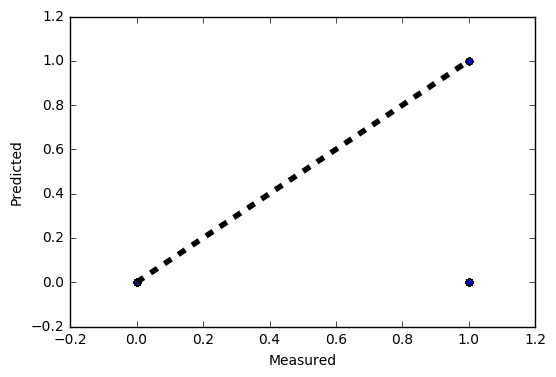

In [106]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(y, y_hat_RF)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [56]:
print rosx.shape
print rosy.shape

(1292L, 60L)
(1292L,)


In [ ]:
from sklearn.linear_model import RidgeClassifierCV
ridge = RidgeClassifierCV (alphas=(0.1, 1.0, 5, 10.0), fit_intercept=False, normalize=True, cv=10)
ridge.fit(X,y)
print "Ridge model:", ridge.coef_

In [ ]:
print sof.sexrecidivism.mean()
# compute null accuracy manually
print y.mean()
print 1 - y.mean()

In [ ]:
# plot mean square error for each fold
m_log_alphascv = -np.log10(model.cv_alphas_)
plt.figure()
plt.plot(m_log_alphascv, model.cv_mse_path_, ':')
plt.plot(m_log_alphascv, model.cv_mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha CV')
plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean squared error')
plt.title('Mean squared error on each fold')

In [ ]:
y_test_hat_RF     

Support Vector Machine

In [39]:
from sklearn import metrics

# SVM Classification
from sklearn.svm import SVC
svc = SVC(probability=True)
svc.fit(X_train, y_train)
y_hat_train_svc = svc.predict(X_train)
print metrics.accuracy_score(y_train, y_hat_train_svc)

risk = [0.05, 0.08, 0.10, 0.15, 0.20, 0.25, 0.30, 0.40, 0.5,0.6, 0.60, 0.70, 0.90]
precision_svc = []
recall_svc = []

for i in risk:
    y_test_hat_svc = (svc.predict_proba(X_test)[:,1] > i).astype(int)
    precision_svc.append(metrics.precision_score(y_test, y_test_hat_svc))
    recall_svc.append(metrics.recall_score(y_test, y_test_hat_svc))
# predict probability of rearrest
y_pred_prob_svc = svc.predict_proba(X_test )[:,1] 
# calculate AUC
print "AUC:",metrics.roc_auc_score(y_test, y_pred_prob_svc)

0.915714285714
AUC: 0.747133826208


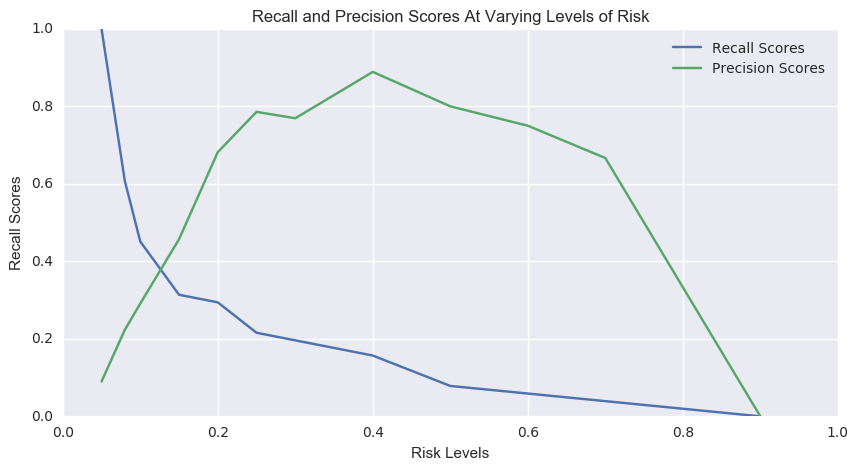

In [40]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,5)) 
plt.plot(risk, recall_svc, label="Recall Scores")
plt.plot(risk, precision_svc, label="Precision Scores")
plt.legend()
plt.axis((0,1,0,1))
plt.xlabel('Risk Levels') 
plt.ylabel('Recall Scores') 
plt.title('Recall and Precision Scores At Varying Levels of Risk') 
plt.show()

In [45]:
# Classification Report
from sklearn.metrics import classification_report
y_test_hat_svc = (svc.predict_proba(X_test)[:,1] > 0.09).astype(int)


In [46]:
svc1=pd.crosstab(y_test, y_test_hat_svc, rownames=['True'], colnames=['Predicted'], margins=True)
svc1


Predicted,0,1,All
True,,,
0,467,82,549
1,26,25,51
All,493,107,600


In [97]:
TN = svc[0][0]
FN = svc[0][1]
FP = svc[1][0]
TP = svc[1][1]
print "True Negative: (TN)", TN 
print "True Positive (TP):", TP 
print "False Negative (FN):", FN 
print "False Positive (FP):", FP 
from __future__ import division
print( "Sensitivity-True positive rate (TPR) (Hit Rate or Recall)", round(TP/(TP+FN),3) )
print "Precision or positive predictive value (PPV)", round(TP/(TP+FP),3)
print "Specificity-True Negative Rate (TNR)", round(TN/(TN+FP),3) 
print "False Negative Rate (FNR) (Miss Rate)", round(FN/(FN+TP),3) 
print "False Positive Rate (FPR) (Fall-out Rate)", round(FP/(FP+TN),3) 
FPR=round(FP/(FP+TN),3) 

True Negative: (TN) 172
True Positive (TP): 18
False Negative (FN): 9
False Positive (FP): 101
('Sensitivity-True positive rate (TPR) (Hit Rate or Recall)', 0.667)
Specificity-True Negative Rate (TNR) 0.63
False Negative Rate (FNR) (Miss Rate) 0.333
False Positive Rate (FPR) (Fall-out Rate) 0.37


# Train-Test Splits

# DEEP LEARNING

In [72]:
y_train.shape

(700L,)

In [35]:

from keras.models import Sequential
from keras.layers import Dense
from sklearn.cross_validation import StratifiedKFold
import numpy

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#X_test=X_test.values

# create model
model = Sequential()
model.add(Dense(3, input_dim=60, init='uniform', activation='relu'))
model.add(Dense(2, init='uniform', activation='relu'))
model.add(Dense(1, init='uniform', activation='sigmoid'))

# Compile model-- the loss func. is to evaluate a set of weights, the optimizer used to search diferent weights for the network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
model.fit(rosx, rosy, validation_data=(X_test, y_test), nb_epoch=150, batch_size=20)

Using Theano backend.


NameError: name 'rosx' is not defined

In [89]:
y_hat_test_dl = model.predict_classes(X_test)


 32/300 [==>...........................] - ETA: 0s

0.0

In [34]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.grid_search import GridSearchCV
import numpy
# Function to create model, required for KerasClassifier
def create_model(optimizer='rmsprop', init='glorot_uniform'):
# create model
    model = Sequential()
    model.add(Dense(4, input_dim=60, init=init, activation='relu'))
    model.add(Dense(3, init=init, activation='relu'))
    model.add(Dense(2, init=init, activation='relu'))
    model.add(Dense(1, init=init, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 3
numpy.random.seed(seed)

#X = X.values
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# grid search epochs, batch size and optimizer
optimizers = ['rmsprop', 'adam']
init = ['glorot_uniform', 'normal', 'uniform']
epochs = numpy.array([100, 200, 300])
batches = numpy.array([10, 20, 30])
param_grid = dict(optimizer=optimizers, nb_epoch=epochs, batch_size=batches, init=init)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

Best: 0.928000 using {'init': 'uniform', 'optimizer': 'adam', 'nb_epoch': 100, 'batch_size': 10}
0.920981 (0.013589) with: {'init': 'glorot_uniform', 'optimizer': 'rmsprop', 'nb_epoch': 100, 'batch_size': 10}
0.922977 (0.016402) with: {'init': 'glorot_uniform', 'optimizer': 'adam', 'nb_epoch': 100, 'batch_size': 10}
0.910977 (0.019744) with: {'init': 'glorot_uniform', 'optimizer': 'rmsprop', 'nb_epoch': 200, 'batch_size': 10}
0.922980 (0.016025) with: {'init': 'glorot_uniform', 'optimizer': 'adam', 'nb_epoch': 200, 'batch_size': 10}
0.912982 (0.014796) with: {'init': 'glorot_uniform', 'optimizer': 'rmsprop', 'nb_epoch': 300, 'batch_size': 10}
0.914978 (0.019889) with: {'init': 'glorot_uniform', 'optimizer': 'adam', 'nb_epoch': 300, 'batch_size': 10}
0.918988 (0.008591) with: {'init': 'normal', 'optimizer': 'rmsprop', 'nb_epoch': 100, 'batch_size': 10}
0.915985 (0.011328) with: {'init': 'normal', 'optimizer': 'adam', 'nb_epoch': 100, 'batch_size': 10}
0.914984 (0.012431) with: {'init': 

In [110]:
X.shape

(1000, 60)

In [129]:
y_hat_test_dl=model.predict_classes(X_test, batch_size=20, verbose=1)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_hat_test_dl)

 20/150 [===>..........................] - ETA: 0s

0.7400336889387984

In [130]:
# Classification Report
from sklearn.metrics import classification_report
report_dl = classification_report(y_test, y_hat_test_dl)
print(report_dl)

             precision    recall  f1-score   support

          0       0.96      0.94      0.95       137
          1       0.47      0.54      0.50        13

avg / total       0.91      0.91      0.91       150



In [ ]:
zip(y_test, y_hat_test_dl)

In [ ]:
dl=pd.crosstab(y_test, y_hat_test_dl, rownames=['True'], colnames=['Predicted'], margins=True)
dl

In [ ]:
# standardize predictors to have mean=0 and sd=1
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [53]:
# Preparing your data using normalization or standardization on the entire training dataset before learning would not
# be a valid test because the training dataset would have been infuenced by the scale of the data in the test set.
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
# create pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('lda', LinearDiscriminantAnalysis()))
model = Pipeline(estimators)
# evaluate pipeline
kfold = KFold(n_splits=10, random_state=3)
results = cross_val_score(model, X, y, cv=kfold)
print(results.mean())

0.9175


In [55]:
# Load libraries
import numpy
from matplotlib import pyplot
from pandas import read_csv
from pandas import set_option
from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

ScaledLR: 0.780610 (0.049312)
ScaledLDA: 0.784002 (0.038876)
ScaledKNN: 0.691833 (0.064991)
ScaledNB: 0.728342 (0.067705)
ScaledSVM: 0.811733 (0.058133)
ScaledGB: 0.849845 (0.053520)
ScaledRF: 0.783698 (0.057097)
ScaledAB: 0.821672 (0.024539)


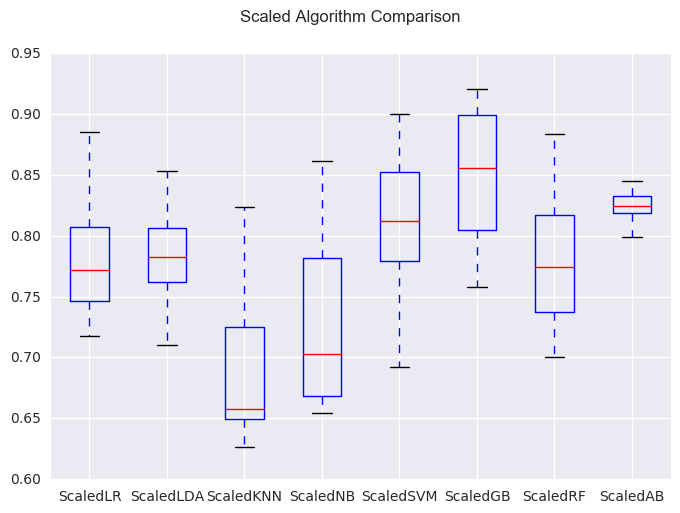

In [57]:
# Compare Algorithms
# Test options and evaluation metric
num_folds = 10
seed = 7

# Standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression())])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()),('LDA', LinearDiscriminantAnalysis())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB', GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC())])))
pipelines.append(('ScaledGB', Pipeline([('Scaler', StandardScaler()),('GB', GradientBoostingClassifier(n_estimators=50, max_depth=20, min_samples_split=8, learning_rate=0.1, random_state=3))])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestClassifier())])))
pipelines.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostClassifier())])))




results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


# boxplot algorithm comparison---you can see the variance among models as well 
fig = pyplot.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()


In [ ]:
predictions = model.predict(rescaledValidationX)


In [58]:
from sklearn.metrics import precision_recall_curve
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
lw = 2

classifier = LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,solver='svd',
                                        store_covariance=False, tol=0.0001)
y_pred = classifier.fit(X_train, y_train).decision_function(X_test)

In [59]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred, average='macro') 

ValueError: Can't handle mix of binary and continuous

In [113]:
for i in models:
    print i

('LR', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))
('LDA', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001))
('KNN', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))
('CART', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))
('NB', GaussianNB(priors=None))
('SVM', SVC(C=1.0, cache_size=200, class_weight=None

In [31]:
y_train.shape

(700L,)

In [ ]:
# Save Model Using Pickle
from pickle import dump
from pickle import load
# Fit the model on 33%
model = LogisticRegression()
model.fit(X_train, Y_train)
# save the model to disk
filename = 'finalized_model.sav'
dump(model, open(filename, 'wb'))

# some time later...
# load the model from disk
loaded_model = load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

In [ ]:
# Save Model Using joblib
from sklearn.externals.joblib import dump
from sklearn.externals.joblib import load
# save the model to disk
filename = 'finalized_model.sav'
dump(model, filename)
# some time later...
# load the model from disk
loaded_model = load(filename)
result = loaded_model.score(X_test, Y_test)
print(result)

In [ ]:
X_train.daystorecid=np.log(X_train.daystorecid)

In [173]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
model = LogisticRegression()
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
matrix = confusion_matrix(Y_test, predicted)
print(matrix)

NameError: name 'LogisticRegression' is not defined

# Grid Search-1

# Grid Search-2

In [ ]:
from sklearn.grid_search import GridSearchCV
GB = GradientBoostingClassifier(random_state=3) param_grid = { "n_estimators" : [30, 50, 70, 100, 150, 200, 250], "learning_rate" : [0.1, 0.01], "max_depth" : [10, 15, 20, 25], "min_samples_split" : [8, 9, 10,11] } grid_search = GridSearchCV(estimator=GB, param_grid=param_grid, cv=10, scoring = 'recall') grid_search.fit(X, y) grid_searchprob = (grid_search.predict_proba(X_test )[:,1] > 0.25).astype(int)
#summarize results
print("Best: %f using %s" % (grid_search.bestscore, grid_search.bestparams, grid_searchprob.bestscore, grid_searchprobparams))

In [ ]:
#Classification Report
from sklearn.metrics import classification_report GB.fit(X_train, y_train) y_test_hat_gb = GB.predict(X_test) reportgb = classification_report(y_test, y_test_hat_gb) print(reportgb)

# Another Parameter Tuning

In [ ]:
import seaborn as sns 
from sklearn.model_selection 
import cross_val_score 
from sklearn import cross_validation 
from matplotlib import pyplot as plt 
import sklearn.cross_validation 


scores = [] 
number_of_trees = [] 
for val in range(50,110): 
    model = GradientBoostingClassifier(n_estimators = val, max_depth=15) 
    validated = cross_val_score(model, X, y, cv=10, scoring ='f1') 
    scores.append(validated) 
    number_of_trees.append(val)
    
scores2 = np.array(scores)
plt.figure(figsize=(25,8)) 
sns.boxplot(number_of_trees, scores) 
plt.xlabel('Number of Trees') 
plt.ylabel('Classification Scores') 
plt.title('Crossvalidated Classification Scores') 
plt.show()

In [ ]:
for i in range(1,60): print scores[i].mean()
len(scores)

In [ ]:
import seaborn as sns 
from sklearn.model_selection 
import cross_val_score 
from sklearn import cross_validation 
from matplotlib import pyplot as plt 
import sklearn.cross_validation 

from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

precision_gb = []
recall_gb = []
risk = [0.05, 0.08, 0.10, 0.15, 0.20, 0.25, 0.30, 0.40, 0.5,0.6, 0.60, 0.70, 0.90]

for i in risk:
    GB = GradientBoostingClassifier(n_estimators=70, max_depth=19, min_samples_split=8, random_state=3)
    recall_gb.append(cross_val_score(GB, X, y, cv=10, scoring ='recall') )
    precision_gb.append(cross_val_score(GB, X, y, cv=10, 'precision'))

    y_test_hat_gb = (GB.predict_proba(X_test )[:,1] > i).astype(int)
    print "i=",i, "Test_Score:", (metrics.accuracy_score(y_test, y_test_hat_gb)), "Hit_Rate:", (metrics.recall_score(y_test, y_test_hat_gb))
    precision_gb.append(metrics.precision_score(y_test, y_test_hat_gb))
    recall_gb.append(metrics.recall_score(y_test, y_test_hat_gb))

y_train_hat_GB = GB.predict(X_train)
print(metrics.accuracy_score(y_train, y_train_hat_GB))
print "Below is Differential Risk"


for i in risk:
    y_test_hat_gb = (GB.predict_proba(X_test )[:,1] > i).astype(int)
    print "i=",i, "Test_Score:", (metrics.accuracy_score(y_test, y_test_hat_gb)), "Hit_Rate:", (metrics.recall_score(y_test, y_test_hat_gb))
    precision_gb.append(metrics.precision_score(y_test, y_test_hat_gb))
    recall_gb.append(metrics.recall_score(y_test, y_test_hat_gb))
    # predict probability of rearrest
y_pred_prob_gb = GB.predict_proba(X_test )[:,1] 
# calculate AUC
print "AUC:",metrics.roc_auc_score(y_test, y_pred_prob_gb)

In [113]:
thresholds

array([ 0.35,  0.4 ,  0.8 ,  2.  ,  8.  ])

In [4]:
sof2.shape

(1000, 567)

In [5]:
sof1.head()

,djjid,sexrecidivism,daystorecid,sexrediccharge,youthgender,race_ethnicity,black,hispanic,other,white,...,d12q9a3,d12q10a1,d12q10a2,d12q10a3,d12q10a4,d12q11a1,d12q11a2,d12q11a3,d12q11a4,d12q11a5
0,959713,0,731,NaN,1,1,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
1,1067533,1,200,4012.0,1,2,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,1192431,0,731,NaN,1,1,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
3,1179012,0,731,NaN,1,3,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0
4,587820,1,74,4007.0,1,1,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0


In [6]:
sof2.head()

,djjid,sexrecidivism,daystorecid,sexrediccharge,youthgender,race_ethnicity,black,hispanic,other,white,...,d12q9a3,d12q10a1,d12q10a2,d12q10a3,d12q10a4,d12q11a1,d12q11a2,d12q11a3,d12q11a4,d12q11a5
0,0.702646,0,78,NaN,1,3,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
1,0.115430,0,731,NaN,1,1,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
2,0.748953,0,87,NaN,1,1,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
3,0.244982,0,160,NaN,1,1,0,0,0,1,...,1,0,0,0,1,0,0,0,0,1
4,0.269714,0,731,NaN,1,2,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0


In [18]:
pd.set_option('display.max_rows', 2000)